<a href="https://colab.research.google.com/github/tangani/New-York-City-Taxi-Fare-Prediction/blob/main/new_york_city_taxi_fare_prediction_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/data_science/new-york-city-taxi-fare-prediction/train.csv', nrows=100000)
test_df = pd.read_csv('/content/drive/MyDrive/data_science/new-york-city-taxi-fare-prediction/test.csv')

In [ ]:
def sigmoid(z): 
  return 1 / (1 + np.exp( - z)) 

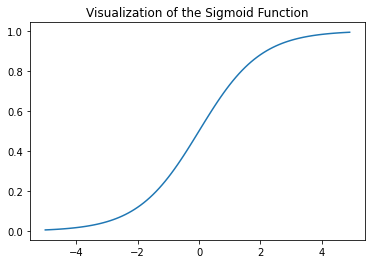

In [ ]:
plt.plot(np.arange(-5, 5, 0.1), sigmoid(np.arange(-5, 5, 0.1))) 
plt.title('Visualization of the Sigmoid Function') 
  
plt.show() 

In [ ]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
train_df.shape

(1000000, 8)

In [ ]:
test_df.shape

(9914, 7)

In [ ]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [ ]:
test_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                9914 non-null   object 
 1   pickup_datetime    9914 non-null   object 
 2   pickup_longitude   9914 non-null   float64
 3   pickup_latitude    9914 non-null   float64
 4   dropoff_longitude  9914 non-null   float64
 5   dropoff_latitude   9914 non-null   float64
 6   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 542.3+ KB


In [ ]:
longitude_nulls = len(train_df[train_df['dropoff_longitude'].isnull()])
latitude_nulls = len(train_df[train_df['dropoff_latitude'].isnull()])
print("There are {} dropoff_longitude values and {} dropoff_latitude values".format(longitude_nulls, latitude_nulls))

There are 10 dropoff_longitude values and 10 dropoff_latitude values


In [ ]:
train_df = train_df.dropna(axis = 0, how ='any')

In [ ]:
# For some reason Google colab uses scientific notation, I get it we are data engineers and thus scientists but that's annoying
train_df.describe().apply(lambda layman: layman.apply('{0:.5f}'.format))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999990.00000,999990.00000,999990.00000,999990.00000,999990.00000,999990.00000
mean,11.34795,-72.52670,39.92904,-72.52786,39.91995,1.68494
std,9.82179,12.05778,7.62609,11.32449,8.20142,1.32391
min,-44.90000,-3377.68094,-3116.28538,-3383.29661,-3114.33857,0.00000
25%,6.00000,-73.99206,40.73497,-73.99138,40.73405,1.00000
50%,8.50000,-73.98179,40.75270,-73.98014,40.75317,1.00000
75%,12.50000,-73.96709,40.76715,-73.96365,40.76813,2.00000
max,500.00000,2522.27133,2621.62843,45.58162,1651.55343,208.00000


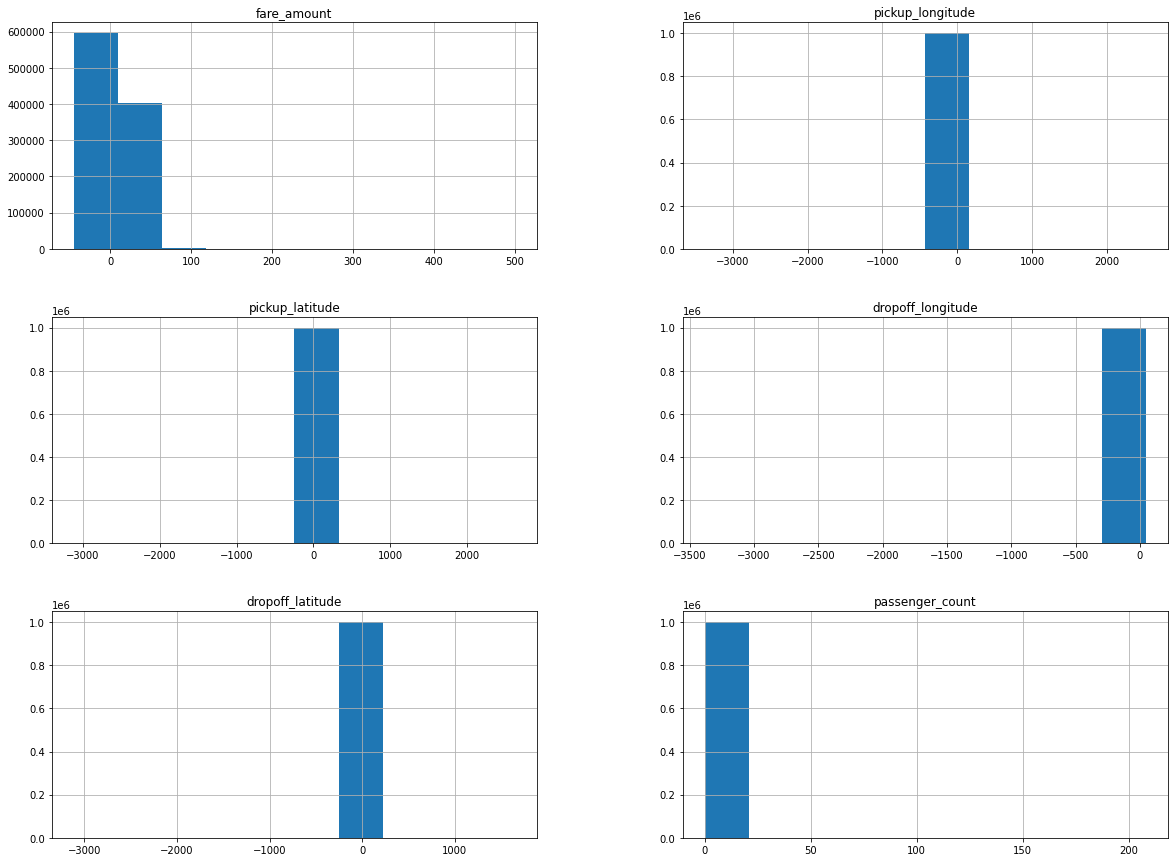

In [ ]:
%matplotlib inline
train_df.hist(figsize=(20,15))
plt.show()

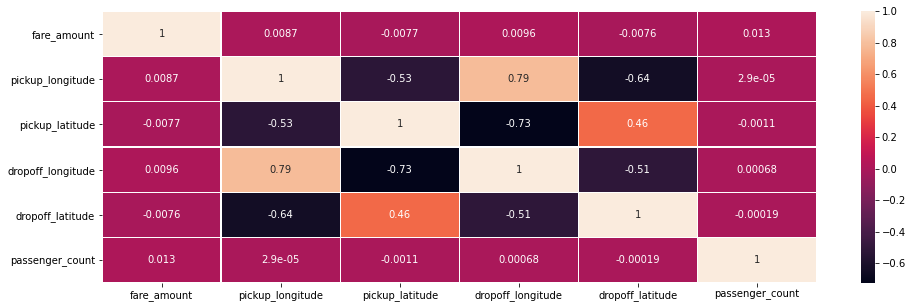

In [ ]:
import seaborn as sns

corr_matrix = train_df.corr()
plt.figure(figsize = (16,5))

sns.heatmap(corr_matrix,
            annot=True,
            linewidths=.5)

In [ ]:
train_df.pickup_datetime = train_df.pickup_datetime.str.slice(0,16)
test_df.pickup_datetime = test_df.pickup_datetime.str.slice(0,16)

In [ ]:
train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime, format='%Y-%m-%d %H:%M')
test_df.pickup_datetime = pd.to_datetime(test_df.pickup_datetime, format='%Y-%m-%d %H:%M')

In [ ]:
def date_extractor(df):
  df['year'] = pd.DatetimeIndex(df['pickup_datetime']).year
  df['month'] = pd.DatetimeIndex(df['pickup_datetime']).month
  df['day'] = pd.DatetimeIndex(df['pickup_datetime']).day
  df['hour'] = pd.DatetimeIndex(df['pickup_datetime']).hour
  df['date'] = pd.DatetimeIndex(df['pickup_datetime']).date

date_extractor(train_df)
date_extractor(test_df)

In [ ]:
def extract_weedkay(df):
  df['weekday'] = pd.to_datetime(df.pickup_datetime).dt.dayofweek

extract_weedkay(train_df)
extract_weedkay(test_df)

In [ ]:
train_df['weekday'].replace(to_replace=[i for i in range(0,7)],
                            value=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                              inplace=True)
test_df['weekday'].replace(to_replace=[i for i in range(0,7)],
                              value=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                              inplace=True)

In [ ]:
train_one_hot=pd.get_dummies(train_df['weekday'])
test_one_hot=pd.get_dummies(test_df['weekday'])
train_df=pd.concat([train_df,train_one_hot],axis=1)
test_df=pd.concat([test_df,test_one_hot],axis=1)

In [ ]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,date,weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,2009-06-15,Monday,0,1,0,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,2010-01-05,Tuesday,0,0,0,0,0,1,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,2011-08-18,Thursday,0,0,0,0,1,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,2012-04-21,Saturday,0,0,1,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,2010-03-09,Tuesday,0,0,0,0,0,1,0


In [ ]:
train_df.drop(['key', 'weekday', 'pickup_datetime', 'date'], axis=1, inplace=True)
test_df.drop(['key', 'weekday', 'pickup_datetime', 'date'], axis=1, inplace=True)

In [ ]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,1,0,0,0,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,0,0,0,0,0,1,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,0,0,0,0,1,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,0,0,1,0,0,0,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,0,0,0,0,0,1,0


In [ ]:
y = train_df['fare_amount']
train_df.drop(['fare_amount'], axis=1, inplace=True)

In [ ]:
train_df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,1,0,0,0,0,0
1,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,0,0,0,0,0,1,0
2,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,0,0,0,0,1,0,0
3,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,0,0,1,0,0,0,0
4,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,0,0,0,0,0,1,0
